In [5]:
import numpy as np
import pandas as pd
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [6]:
X = pd.read_csv("../../datasets/agrawal.csv").head(5000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [7]:
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline


In [8]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", random_forest),
]
sail_pipeline = SAILPipeline(steps=steps, verbosity_level=1)

#### Train Test Split


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Start Incremental Training


In [10]:
y_preds = []
y_true = []
batch_size = 100

for start in range(0, X_train.shape[0], batch_size):

    end = start + batch_size

    X = X_train.iloc[start:end]
    y = y_train.iloc[start:end]


    sail_pipeline.partial_fit(X, y, classifier__classes=[1, 0])


    
>> Epoch: 1 | Samples Seen: 0 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.086s, Batch Size=100, P_Score=0]             

    
>> Epoch: 2 | Samples Seen: 100 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.075s, Batch Size=100, P_Score=0.75]             

    
>> Epoch: 3 | Samples Seen: 200 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.085s, Batch Size=100, P_Score=0.785]             

    
>> Epoch: 4 | Samples Seen: 300 -------------------------------------------------------------------------------------
SAIL Pipeline Partial fit: 100%========== [Steps: 3/3, ETA: 00:00<00:00, Elapsed:0.091s, Batch Size=100, P_Score

#### Save SAIL Pipeline


In [12]:
sail_pipeline.save(".")

[2023-12-15 12:23:45:720] - INFO - SAIL (SAILModel) - Model saved successfully.


'./sail_pipeline'

#### Load SAIL Pipeline


In [17]:
sail_new_pipeline = SAILPipeline.load(".")

[2023-12-15 12:24:22:217] - INFO - SAIL (SAILModel) - Model loaded successfully.
SAIL Pipeline Progressive Score: 100%========== [Points: 3400/3400, Elapsed:0.0047s, Metric=Accuracy, Batch Size=3400, P_Score=0.922]


#### Make Prediction on the Hold out set


In [18]:
y_preds = []
y_true = []
batch_size = 100

for start in range(0, X_test.shape[0], batch_size):

    end = start + batch_size

    X = X_test.iloc[start:end]
    y = y_test.iloc[start:end]

    preds = sail_new_pipeline.predict(X)
    y_preds.extend(list(preds))
    y_true.extend(list(y))

#### Classification Report


In [19]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       992
           1       0.94      0.89      0.91       508

    accuracy                           0.94      1500
   macro avg       0.94      0.93      0.94      1500
weighted avg       0.94      0.94      0.94      1500



#### Plot confusion matrix


<Axes: >

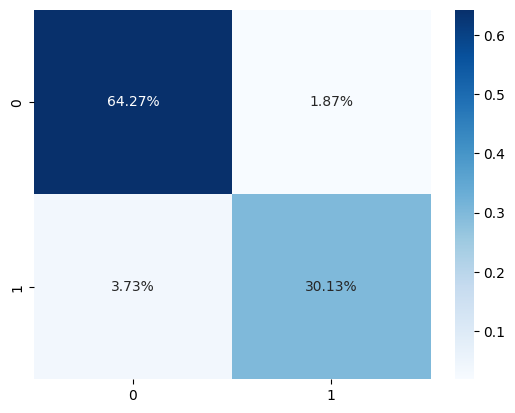

In [20]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')